In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# def gpr_1d(x,  mean, sigma):
#     return np.sin(x) + 2 * np.sin(6 * x) #+ np.random.normal(loc=mean, scale=sigma, size=x.shape[0])

# mean=0.0
# sigma= 0.1
# x= np.linspace(-2, 2, 100)
# y= gpr_1d(x, mean, sigma)


Text(0, 0.5, 'y')

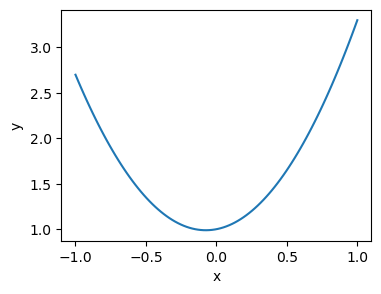

In [3]:
def gpr_1d(x, a, b, c, d):
    return a*x**5+b*x**2+c*x+d
x= np.linspace(-1, 1, 100)
a= 0
b=2
c= 0.3
d=1 # uT
y= gpr_1d(x, a, b, c, d)
plt.figure(figsize= (4,3))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')

In [4]:
class SimpleNN(nn.Module):
    def __init__(self, neurons=64):  
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, neurons)  
        self.fc2 = nn.Linear(neurons, 1)  
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
x_train = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)
y_train = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

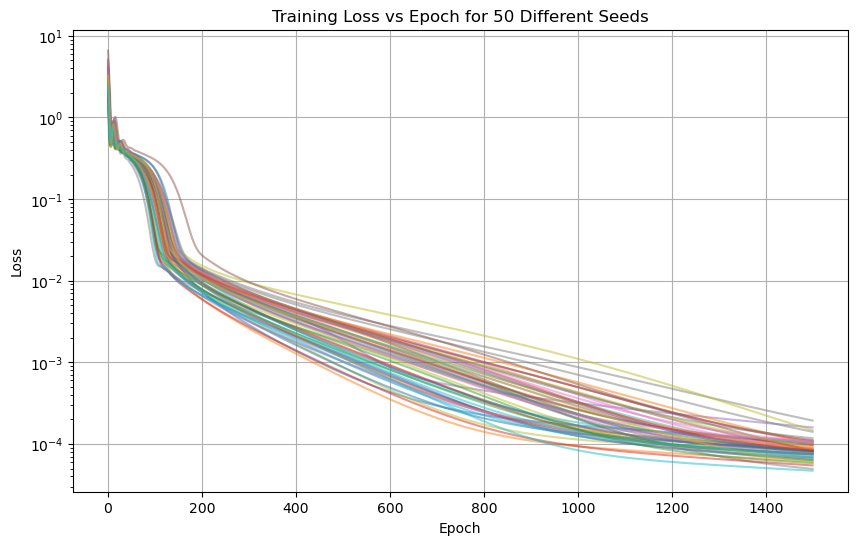

In [6]:

all_predictions = []
all_losses = []

num_seeds = 50
for seed in range(num_seeds):
    torch.manual_seed(seed)

    model = SimpleNN(neurons=64)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    losses = []
    epochs = 1500
    

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        

        losses.append(loss.item())

    y_pred = model(x_train).detach().numpy()
    all_predictions.append(y_pred)
    all_losses.append(losses)



plt.figure(figsize=(10, 6))
for i in range(num_seeds):
    plt.semilogy(range(epochs), all_losses[i], alpha=0.5, label=f'Seed {i}' if i < 5 else "")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch for 50 Different Seeds')
plt.grid(True)
plt.show()

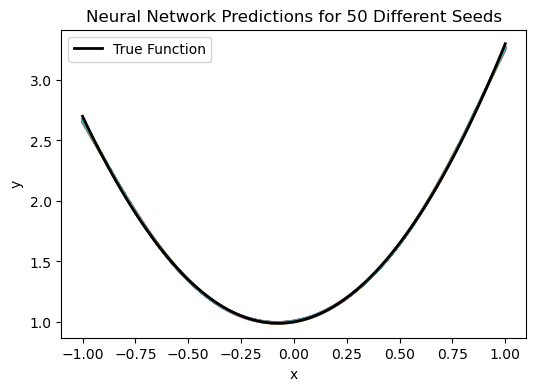

In [16]:
all_predictions = np.array(all_predictions)

plt.figure(figsize=(6, 4))
for i in range(num_seeds):
    plt.plot(x, all_predictions[i], alpha=1)
plt.plot(x, y, color='black', label='True Function', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Network Predictions for 50 Different Seeds')
plt.legend()
plt.show()

/var/folders/xx/4ld5w3397h1416_knlp6ytmc0000gn/T/ipykernel_74145/3837861631.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', num_seeds)  # Choose a colormap with num_seeds colors


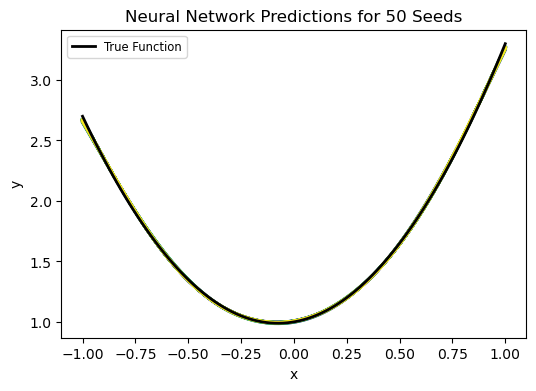

In [19]:

all_predictions = np.array(all_predictions)


cmap = plt.cm.get_cmap('viridis', num_seeds)  # Choose a colormap with num_seeds colors

plt.figure(figsize=(6, 4))


for i in range(num_seeds):
    plt.plot(x, all_predictions[i], color=cmap(i), alpha=1, linewidth= 2)#, label=f'Seed {i + 1}' if i < 10 else "")  # Label first few seeds

plt.plot(x, y, color='black', label='True Function', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Network Predictions for 50 Seeds')
plt.legend(loc='best', fontsize='small', ncol=2)  # Adjust legend position and size
plt.show()


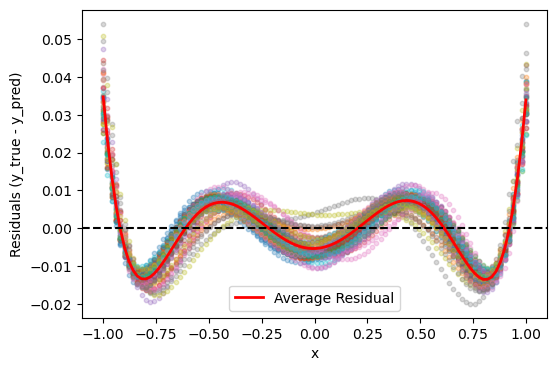

In [8]:

all_predictions = np.array(all_predictions).squeeze()  # Shape: (50, 100)


all_residuals = []
for i in range(num_seeds):
    residuals = y - all_predictions[i]
    all_residuals.append(residuals)

all_residuals = np.array(all_residuals)

x_flat = x.flatten()


plt.figure(figsize=(6,4))

for i in range(num_seeds):
    plt.scatter(x_flat, all_residuals[i], alpha=0.3, s=10)

average_residuals = np.mean(all_residuals, axis=0)
plt.plot(x_flat, average_residuals, color='red', label='Average Residual', linewidth=2)

plt.xlabel('x')
plt.ylabel('Residuals (y_true - y_pred)')
plt.axhline(0, color='black', linestyle='--') 
plt.legend()
plt.show()

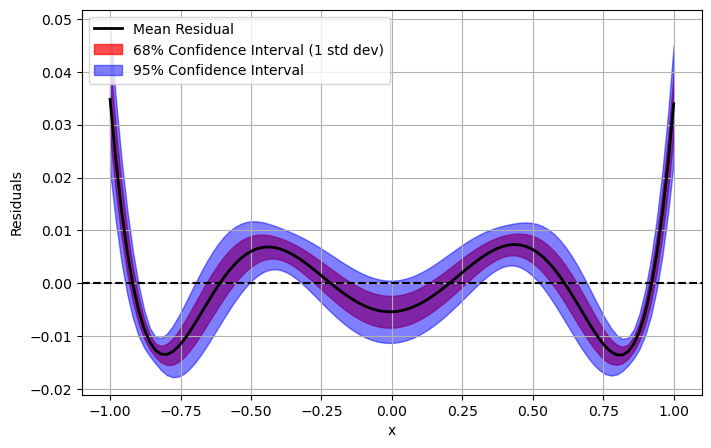

In [9]:

mean_residuals = np.mean(all_residuals, axis=0)
std_residuals = np.std(all_residuals, axis=0)

ci_68_lower = mean_residuals - std_residuals
ci_68_upper = mean_residuals + std_residuals
ci_95_lower = mean_residuals - 1.96 * std_residuals
ci_95_upper = mean_residuals + 1.96 * std_residuals


plt.figure(figsize=(8, 5))

plt.plot(x_flat, mean_residuals, color='black', label='Mean Residual', linewidth=2)


plt.fill_between(
    x_flat, 
    ci_68_lower, 
    ci_68_upper, 
    color='red', alpha=0.7, label='68% Confidence Interval (1 std dev)'
)


plt.fill_between(
    x_flat, 
    ci_95_lower, 
    ci_95_upper, 
    color='blue', alpha=0.5, label='95% Confidence Interval'
)


plt.xlabel('x')
plt.ylabel('Residuals')
plt.axhline(0, color='k', linestyle='--')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

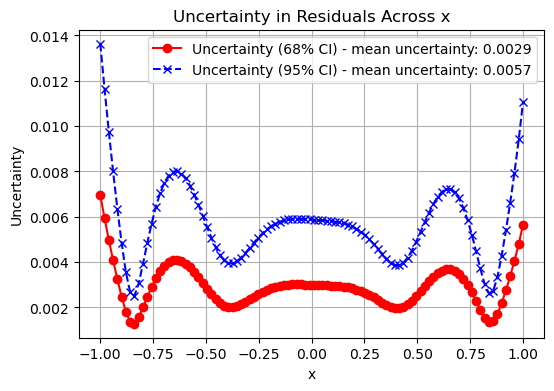

In [10]:

uncertainty_1_sigma = std_residuals
uncertainty_1_96_sigma = 1.96 * std_residuals

avg_1_sigma = np.mean(uncertainty_1_sigma)
avg_1_96_sigma = np.mean(uncertainty_1_96_sigma)


plt.figure(figsize=(6, 4))


plt.plot(x_flat, uncertainty_1_sigma, color='red', marker='o', linestyle='-', 
         label=f'Uncertainty (68% CI) - mean uncertainty: {avg_1_sigma:.4f}')

plt.plot(x_flat, uncertainty_1_96_sigma, color='blue', marker='x', linestyle='--', 
         label=f'Uncertainty (95% CI) - mean uncertainty: {avg_1_96_sigma:.4f}')

plt.xlabel('x')
plt.ylabel('Uncertainty')
plt.title('Uncertainty in Residuals Across x')
plt.grid(True)
plt.legend()
plt.show()